In [1]:
1+1

2

In [4]:
spec_data = False

import numpy as np
import pylab as plt

from pynx.utils.array import rebin as pynx_rebin

import sys
sys.path.append('/data/id01/inhouse/bellec/software/sharedipynb/gitlab/bcdi_eb/')
from PreProcessing import *
from Plot_utilities import *
from Global_utilities import *

if spec_data:
    from specutils import *
else:
    from h5utils import *

In [5]:
filename = '/data/visitor/hc4050/id01/20240130/RAW_DATA/Pd_GC/Pd_GC_0002/Pd_GC_0002.h5'
# filename = '/data/visitor/hc4050/id01/restored_dataset/niBCDI20201106012505/spec/BCDI_2020_11_06_012505.spec'

scanList = get_scans_title_str_hdf5(filename, '')
# scanList = get_scans_title_str_hdf5(filename, '', verbose=False)

In [6]:
scan_no = 1
scan = openScan(filename, scan_no, verbose=True)

OSError: Unable to open file (file signature not found)

In [5]:
# # If you need to check the scan motor positions
# motor_list = ['thx', 'thy', 'thz', 'pix', 'piy', 'piz', 'eta', 'nu', 'delta']
# scan.print_scan_motors(motor_list)

In [6]:
roi_images = [None,None,None,None]
data = scan.getImages(roi=roi_images)
det_sum = np.sum(data, axis=0)

data.shape (101, 516, 516)


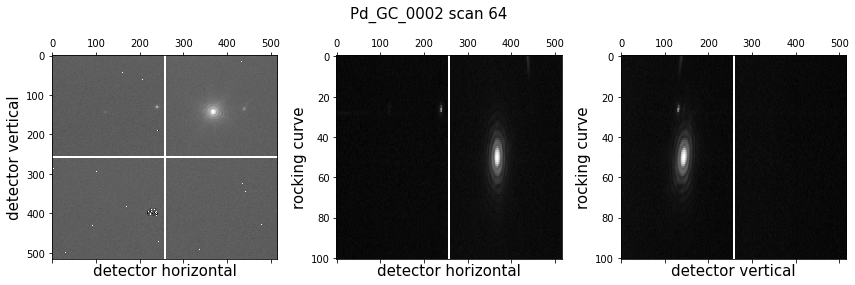

In [7]:
plot_3D_projections(data,axes_labels=True, fig_title='{} scan {}'.format(scan.h5file.split('/')[-1][:-3], 
                                                                 scan.scan_string[:-2]))

# Create a mask

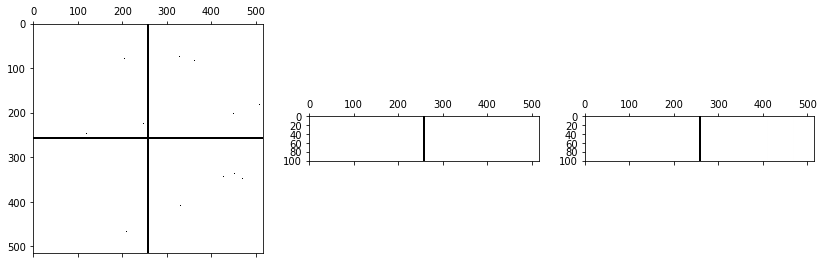

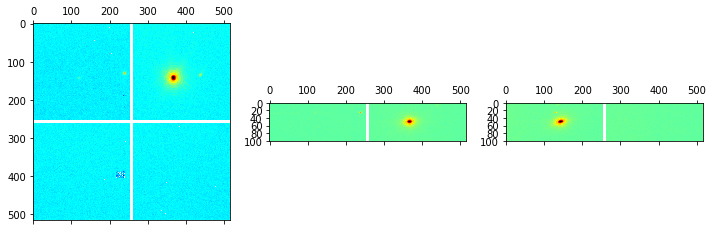

In [8]:
mask = load_mask(scan, data=data,
                 roi=roi_images,
                 plot=True)

# Select a ROI

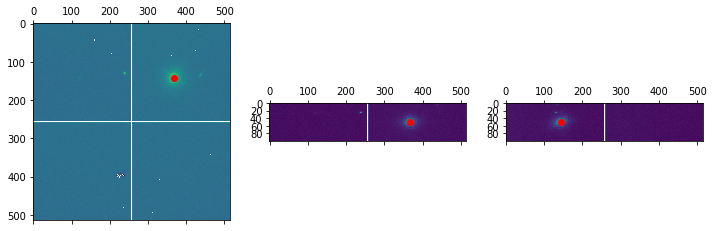

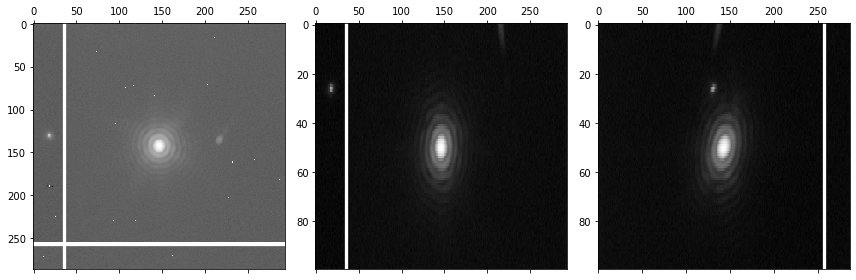

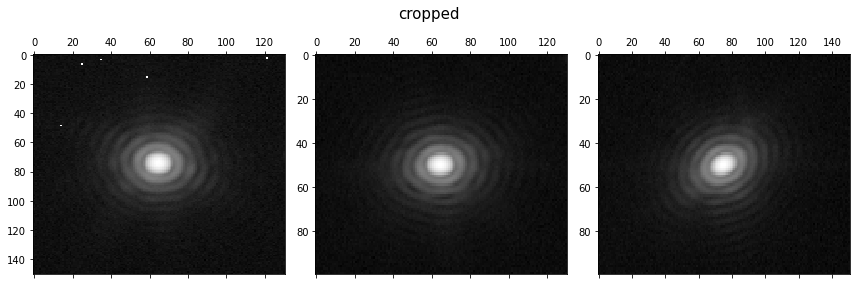

In [9]:
roi_init = [0,-1,0,-1,0,-1]

crop_with_final_size = True
final_size_array = [None,150,130]

roi = automatic_roi_selection(data,
                              roi_init=roi_init,
                              crop_with_final_size=crop_with_final_size, final_size_array=final_size_array,
                              plot=True)

In [10]:
# Apply the ROI once you think it's fine (run this cell only once ! )

data = data[roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]]
mask = mask[roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]]

In [11]:
check_detector_saturation(data, scan)

maximum counts :  25360


# Create q array (for future orthogonalization)

In [12]:
# det_calib = {'distance': 1.1326099021792053,
#              'beam_center_x': 484.8384115882237,
#              'beam_center_y': 1375.3714152892385,
#              'x_pixel_size': 7.5e-05,
#              'y_pixel_size': 7.5e-05}

det_calib = None

qx,qy,qz = create_Q_array(scan,
                          roi = roi,
                          det_calib=det_calib,
                          chi=0,
                          verbose=True)

detector calibration has a negative distance. Forcing it positive
phi : 0.0
eta : [12.67955306 12.6895561  12.69954393 12.70954697 12.71955002 12.72955306
 12.7395561  12.74954393 12.75954697 12.76955002 12.77955306 12.7895561
 12.79954393 12.80954697 12.81955002 12.82955306 12.8395561  12.84954393
 12.85954697 12.86955002 12.87955306 12.8895561  12.89954393 12.90954697
 12.91955002 12.92955306 12.9395561  12.94954393 12.95954697 12.96955002
 12.97955306 12.9895561  12.99954393 13.00954697 13.01955002 13.02955306
 13.0395561  13.04954393 13.05954697 13.06955002 13.07955306 13.0895561
 13.09954393 13.10954697 13.11955002 13.12955306 13.1395561  13.14954393
 13.15954697 13.16955002 13.17955306 13.1895561  13.19954393 13.20954697
 13.21955002 13.22955306 13.2395561  13.24954393 13.25954697 13.26955002
 13.27955306 13.2895561  13.29954393 13.30954697 13.31955002 13.32955306
 13.3395561  13.34954393 13.35954697 13.36955002 13.37955306 13.3895561
 13.39954393 13.40954697 13.41955002 13.42955

# Flatfield

In [13]:
flatfield_correction = False

In [14]:
if flatfield_correction:

    flatfield_file = '/data/id01/inhouse/data_analysis/spatcorr-files/mpx22/ff_20200825_20kev_gaas/ff.h5'
    data = correct_flatfield(data, roi,
                          flatfield_file,
                          plot=True)

# Rebin data

current calculated oversampling ratio : [3.15625    4.71875    4.67857143]
Possibility to rebin :  [1 2 2]
oversampling after rebinning :  [3.15625    2.359375   2.33928571]


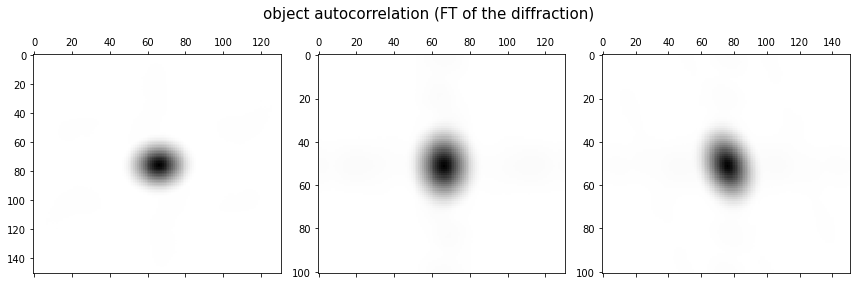

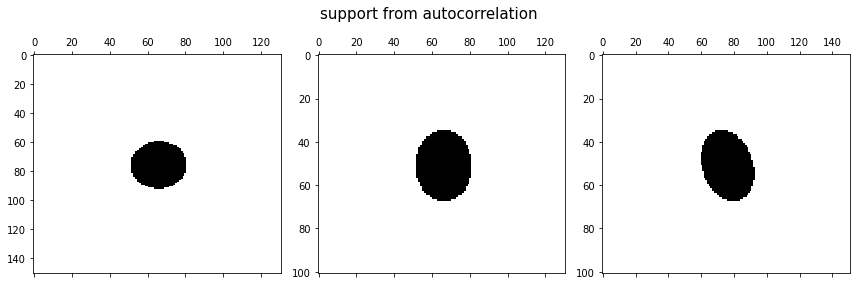

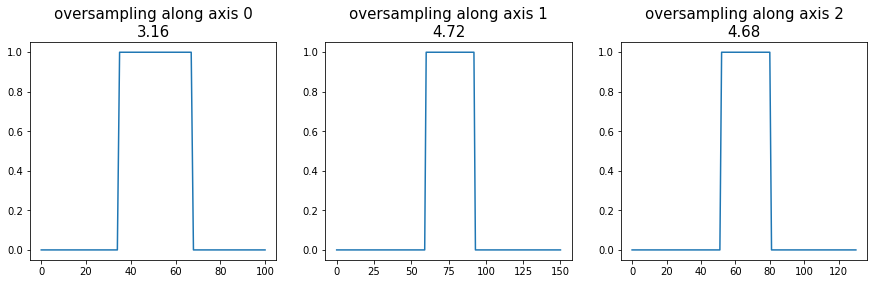

In [15]:
guess_rebinning = True

if guess_rebinning:
    support_threshold = .1 # threshold to create the support from the autocorrelation (FT of the diffraction)
    oversampling, rebinning_possibility = oversampling_from_diffraction(data, # data is the 3D diffraction array
                                      support_threshold=support_threshold,
                                      plot=True)

In [16]:
rebin = False # If you're not sure, kepp rebin=False as a first try.
rebinning = rebinning_possibility # Select the guessed rebinning
# rebinning = (2,3,1) # Or just give yours

if rebin :
    data_rebin = pynx_rebin(data, rebinning)
    plot_3D_projections(data, fig_title='original data')
    plot_3D_projections(data_rebin, fig_title='rebin data')

In [17]:
if rebin :
    data = data_rebin
    qx = pynx_rebin(qx, rebinning, scale='average')
    qy = pynx_rebin(qy, rebinning, scale='average')
    qz = pynx_rebin(qz, rebinning, scale='average')

    mask = pynx_rebin(mask, rebinning, scale='average')
    mask[mask!=0] = 1

# Make the orthogonalization in preprocessing (optional)

In [18]:
# Don't so that except if you have a good reason. This makes the reconstruction harder.
orthogonalization = False

if orthogonalization :
    data, mask, qx, qy, qz =  Q_space_transformation(data,
                                                   qx,qy,qz,
                                                   mask=mask,
                                                     return_3D_q=True,
                                                   plot=True)

## Crop data after orthogonalization (optional)

In [19]:
cropping_final = False

if cropping_final:
    crop = [55,0,0]
    data_crop = np.copy(data[crop[0]:-crop[0] or None, crop[1]:-crop[1] or None, crop[2]:-crop[2] or None])
    plot_3D_projections(data)
    plot_3D_projections(data_crop)

In [20]:
if cropping_final:
    data = data[crop[0]:-crop[0] or None, crop[1]:-crop[1] or None, crop[2]:-crop[2] or None]
    qx = qx[crop[0]:-crop[0] or None, crop[1]:-crop[1] or None, crop[2]:-crop[2] or None]
    qy = qy[crop[0]:-crop[0] or None, crop[1]:-crop[1] or None, crop[2]:-crop[2] or None]
    qz = qz[crop[0]:-crop[0] or None, crop[1]:-crop[1] or None, crop[2]:-crop[2] or None]
    mask = mask[crop[0]:-crop[0] or None, crop[1]:-crop[1] or None, crop[2]:-crop[2] or None]

# Calculate q center

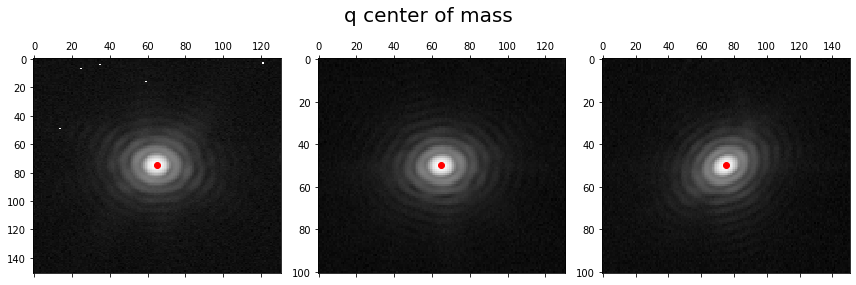

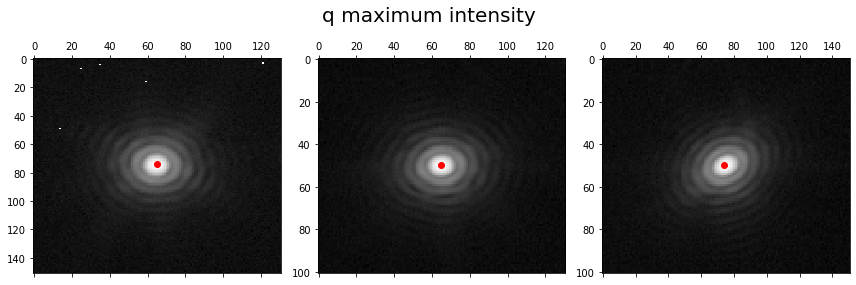

In [21]:
qcen = calculate_Q_center_of_mass(data, 
                             qx,qy,qz,
                             remove_min=True, plot=True)

qmax = calculate_qmax(data, 
                   qx,qy,qz,
                   plot=True)

# Make sure all dimensions are even (not great but it will avoid problems)

In [22]:
data, qx,qy,qz, mask = force_even_dimension(data, qx,qy,qz, mask, verbose=True)

shape changed :

qx (101, 151, 131) to (100, 150, 130)
qy (101, 151, 131) to (100, 150, 130)
qz (101, 151, 131) to (100, 150, 130)
data (101, 151, 131) to (100, 150, 130)
mask (101, 151, 131) to (100, 150, 130)


# Save the pre-processed data

In [23]:
savename_add_string = ''

if rebin:
    savename_add_string += '_rebin'
    savename_add_string +='_{}_{}_{}'.format(rebinning[0], rebinning[1], rebinning[2])

if flatfield_correction:
    savename_add_string += '_flatfield'
    
print('savename_add_string : ', savename_add_string)

savename_add_string :  


In [24]:
save_preprocessed_data(scan, data, qx,qy,qz,orthogonalization=orthogonalization,
                           mask=mask,
                           qcen=qcen, qmax=qmax,
                       savename_add_string = savename_add_string,
                      verbose=True)

preprocessed data saved in : preprocessed_data_Pd_GC/dataset_Pd_GC_0002_scan_64.npz
data saved in :  preprocessed_data_Pd_GC/dataset_Pd_GC_0002_scan_64


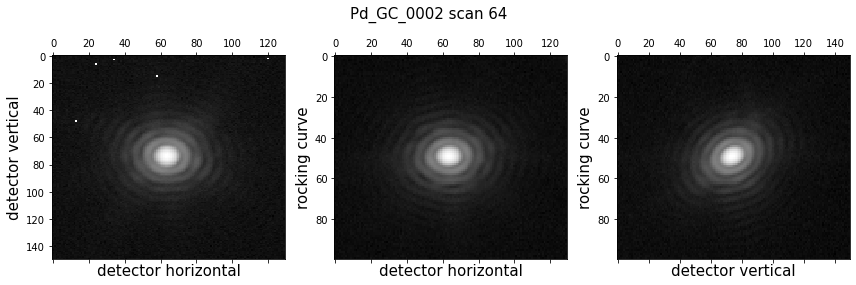

In [25]:
plot_3D_projections(data,axes_labels=True, fig_title='{} scan {}'.format(scan.h5file.split('/')[-1][:-3], 
                                                                 scan.scan_string[:-2]))

In [26]:
del(data)